In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 30
pd.options.display.float_format = '{:,.3f}'.format

## Load the data

In [2]:
movies = pd.read_csv('data/movies_clean.csv')
ratings = pd.read_csv('data/ratings_train.csv')

## Compute scores

In [3]:
movie_scores = ratings.groupby(['movie_id']).rating.agg(['count', 'mean', 'std'])
movie_scores.columns = ['ratings_cnt', 'ratings_avg', 'ratings_std']
movie_scores.sample(10)

,ratings_cnt,ratings_avg,ratings_std
movie_id,,,
93911,1,3.000,nan
94044,7,3.214,1.254
127831,1,3.500,nan
66927,4,4.000,0.913
70521,93,3.656,0.970
33358,131,3.660,0.912
99679,4,2.750,1.658
104633,1,3.500,nan
333,8780,3.348,1.065


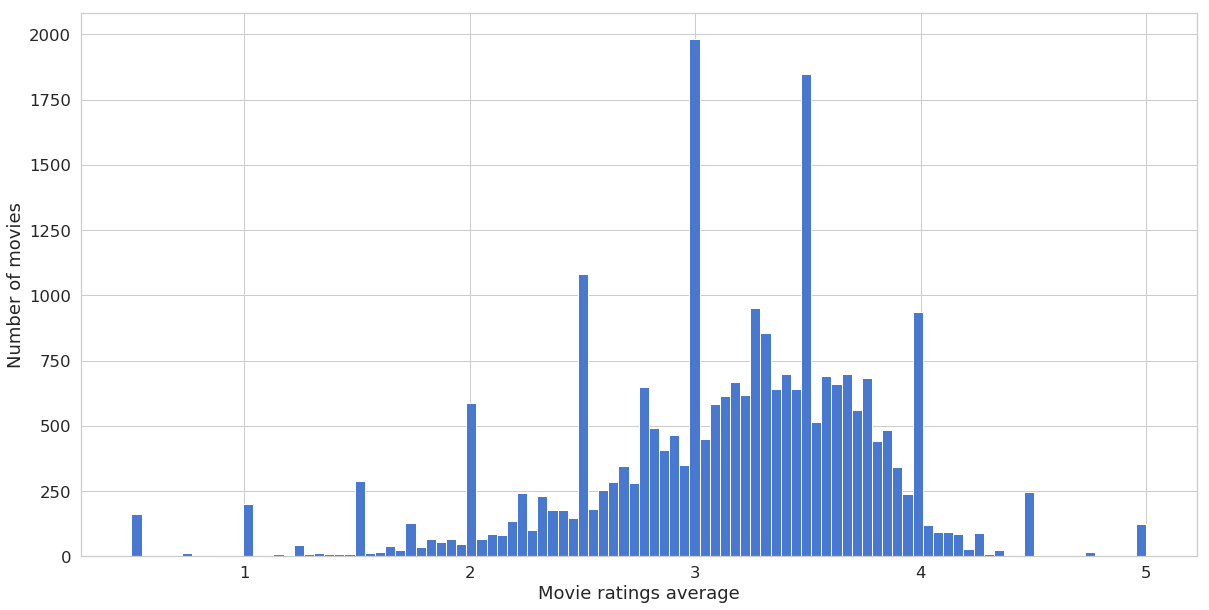

In [4]:
plt.figure(figsize=(20, 10))
plt.hist(movie_scores.ratings_avg.dropna(), bins=100)
plt.xlabel('Movie ratings average')
plt.ylabel('Number of movies')
plt.show()

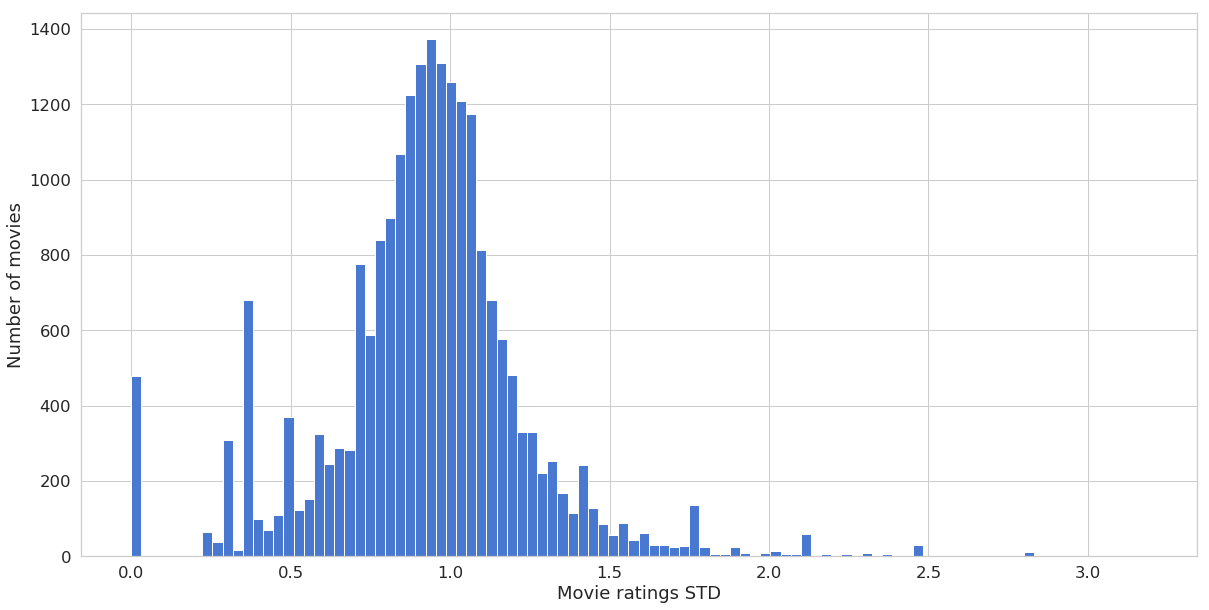

In [5]:
plt.figure(figsize=(20, 10))
plt.hist(movie_scores.ratings_std.dropna(), bins=100)
plt.xlabel('Movie ratings STD')
plt.ylabel('Number of movies')
plt.show()

In [6]:
zscore_cols = ['ratings_avg', 'ratings_std']
for col in zscore_cols:
    mean = movie_scores[col].mean()
    std = movie_scores[col].std()
    movie_scores[col + '_zscore'] = (movie_scores[col] - mean) / std

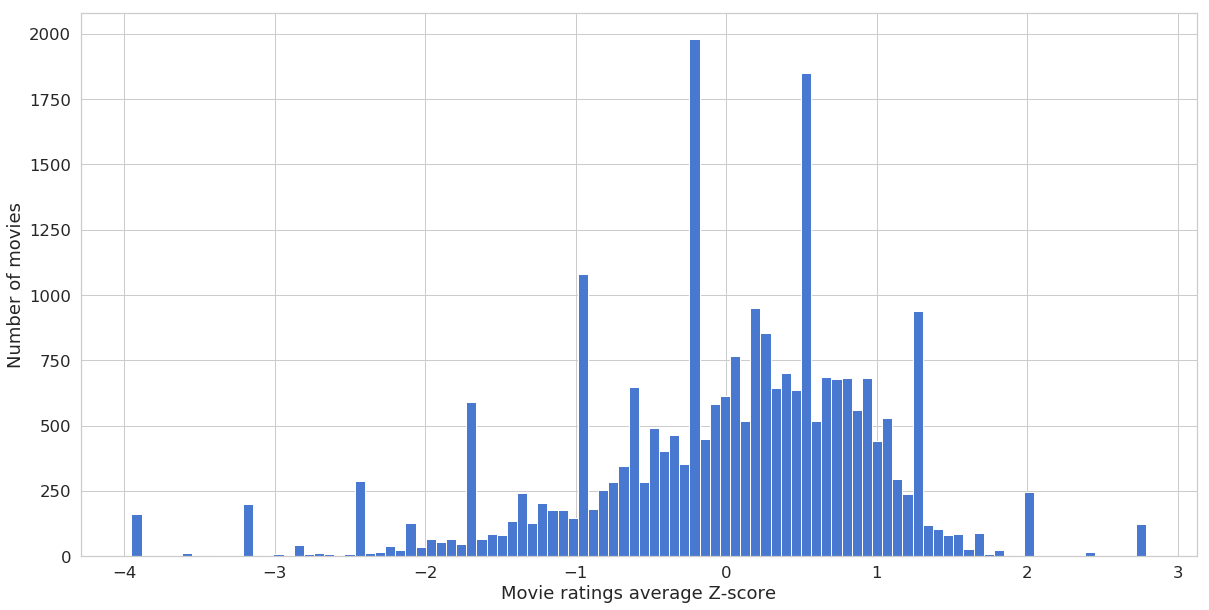

In [7]:
plt.figure(figsize=(20, 10))
plt.hist(movie_scores.ratings_avg_zscore.dropna(), bins=100)
plt.xlabel('Movie ratings average Z-score')
plt.ylabel('Number of movies')
plt.show()

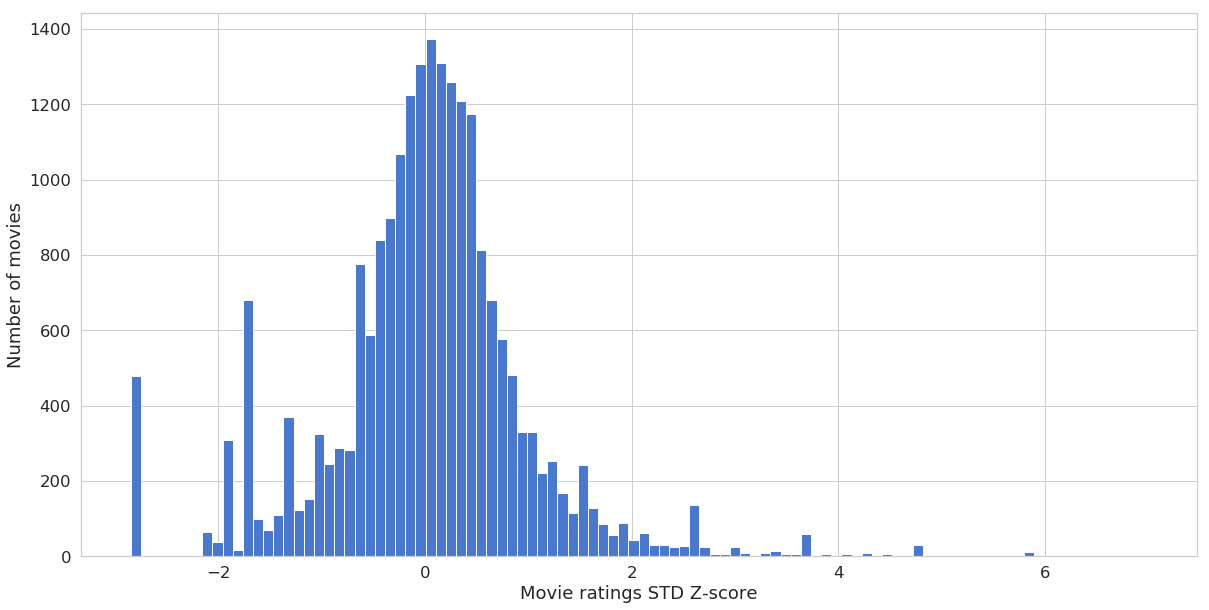

In [8]:
plt.figure(figsize=(20, 10))
plt.hist(movie_scores.ratings_std_zscore.dropna(), bins=100)
plt.xlabel('Movie ratings STD Z-score')
plt.ylabel('Number of movies')
plt.show()

In [9]:
movie_scores['ratings_avg_qcut'] = pd.qcut(
    movie_scores.ratings_avg + (0.0001 * np.random.randn(len(movie_scores))),
    1000,
    labels=range(1, 1001)).astype(float)
movie_scores['ratings_std_qcut'] = pd.qcut(
    movie_scores.ratings_std + (0.0001 * np.random.randn(len(movie_scores))),
    1000,
    labels=range(1, 1001)).astype(float)

In [10]:
movies = pd.merge(movies, movie_scores, left_on='movie_id', right_index=True)
movies['age'] = 2019 - movies.year
movies.sample(5).T

,8429,7911,25277,1041,19691
movie_id,25854,8594,119196,1061,97395
title,Intermezzo (1939),"Secret Life of Girls, The ...",Heartbeat (1938),Sleepers (1996),West of Memphis (2012)
year,"1,939.000","1,999.000","1,938.000","1,996.000","2,012.000"
parsed_genres,"['drama', 'romance']",['comedy'],['comedy'],['thriller'],['documentary']
genre_adventure,0,0,0,0,0
genre_children,0,0,0,0,0
genre_animation,0,0,0,0,0
genre_thriller,0,0,0,1,0
genre_crime,0,0,0,0,0
genre_action,0,0,0,0,0


In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25871 entries, 0 to 27277
Data columns (total 32 columns):
movie_id                25871 non-null int64
title                   25871 non-null object
year                    25852 non-null float64
parsed_genres           25871 non-null object
genre_adventure         25871 non-null int64
genre_children          25871 non-null int64
genre_animation         25871 non-null int64
genre_thriller          25871 non-null int64
genre_crime             25871 non-null int64
genre_action            25871 non-null int64
genre_scifi             25871 non-null int64
genre_fantasy           25871 non-null int64
genre_war               25871 non-null int64
genre_musical           25871 non-null int64
genre_filmnoir          25871 non-null int64
genre_romance           25871 non-null int64
genre_western           25871 non-null int64
genre_nogenreslisted    25871 non-null int64
genre_horror            25871 non-null int64
genre_imax              25871 no

## Some charts

### Top rated horror movies

In [12]:
print(movies[movies.genre_horror == 1].ratings_cnt.quantile([0.8 + i*0.05 for i in range(5)]))
d = movies[(movies.genre_horror == 1) & (movies.ratings_cnt > 20)].copy()
d['score'] = (
    + 1.0 * d.ratings_avg_qcut
    - 0.2 * d.ratings_std_qcut
    + 0.001 * d.ratings_cnt)
d = d.sort_values(by='score', ascending=False)
d.head(10)[['movie_id', 'title', 'year', 'parsed_genres', 'ratings_avg', 'ratings_avg_qcut', 'ratings_std', 'ratings_std_qcut', 'ratings_cnt', 'score']]

0.800      254.000
0.850      452.850
0.900      913.700
0.950    1,998.250
1.000   50,666.000
Name: ratings_cnt, dtype: float64


,movie_id,title,year,parsed_genres,ratings_avg,ratings_avg_qcut,ratings_std,ratings_std_qcut,ratings_cnt,score
587,593,"Silence of the Lambs, The ...","1,991.000","['crime', 'horror', 'thril...",4.178,979.000,0.840,329.000,50666,963.866
2676,2762,"Sixth Sense, The (1999)","1,999.000","['drama', 'horror', 'myste...",4.054,969.000,0.830,313.000,31301,937.701
1193,1219,Psycho (1960),"1,960.000","['crime', 'horror']",4.075,970.000,0.860,360.000,15677,913.677
1188,1214,Alien (1979),"1,979.000","['horror', 'scifi']",4.036,967.000,0.887,409.000,24692,909.892
7004,7116,Diabolique (Les diabolique...,"1,955.000","['horror', 'mystery', 'thr...",4.002,963.000,0.801,274.000,839,909.039
12932,61240,Let the Right One In (Låt ...,"2,008.000","['drama', 'fantasy', 'horr...",4.019,965.000,0.820,298.000,2457,907.857
1230,1258,"Shining, The (1980)","1,980.000",['horror'],4.011,964.000,0.882,401.000,18744,902.544
1175,1200,Aliens (1986),"1,986.000","['action', 'adventure', 'h...",4.002,963.000,0.897,426.000,21850,899.650
7987,8670,"Testament of Dr. Mabuse, T...","1,933.000","['crime', 'horror', 'myste...",3.979,930.000,0.811,286.000,194,872.994
9176,27033,"Kingdom II, The (Riget II)...","1,997.000","['drama', 'horror', 'myste...",4.004,963.000,0.941,510.000,134,861.134


### Controversial horror movies

In [13]:
print(movies[movies.genre_horror == 1].ratings_cnt.quantile([0.8 + i*0.05 for i in range(5)]))
d = movies[(movies.genre_horror == 1) & (movies.ratings_cnt > 20)].copy()
d['score'] = (
    + 1.0 * d.ratings_avg_qcut
    + 1.0 * d.ratings_std_qcut
    + 0.001 * d.ratings_cnt)
d = d.sort_values(by='score', ascending=False)
d.head(10)[['movie_id', 'title', 'year', 'parsed_genres', 'ratings_avg', 'ratings_avg_qcut', 'ratings_std', 'ratings_std_qcut', 'ratings_cnt', 'score']]

0.800      254.000
0.850      452.850
0.900      913.700
0.950    1,998.250
1.000   50,666.000
Name: ratings_cnt, dtype: float64


,movie_id,title,year,parsed_genres,ratings_avg,ratings_avg_qcut,ratings_std,ratings_std_qcut,ratings_cnt,score
14745,73759,Hellsing Ultimate OVA Seri...,"2,006.000","['action', 'animation', 'h...",3.816,882.000,1.152,838.000,144,"1,720.144"
12393,57502,Cat Soup (Nekojiru-so) (2001),"2,001.000","['adventure', 'animation',...",3.798,875.000,1.127,814.000,109,"1,689.109"
4309,4404,Faust (1926),"1,926.000","['drama', 'fantasy', 'horr...",3.785,869.000,1.092,775.000,228,"1,644.228"
3115,3202,Even Dwarfs Started Small ...,"1,971.000","['drama', 'horror']",3.624,778.000,1.186,865.000,105,"1,643.105"
738,751,Careful (1992),"1,992.000","['comedy', 'horror']",3.523,725.000,1.268,910.000,131,"1,635.131"
3585,3676,Eraserhead (1977),"1,977.000","['drama', 'horror']",3.601,767.000,1.177,858.000,2068,"1,627.068"
4563,4658,Santa Sangre (1989),"1,989.000","['drama', 'horror', 'myste...",3.632,785.000,1.147,833.000,272,"1,618.272"
1213,1241,Dead Alive (Braindead) (1992),"1,992.000","['comedy', 'fantasy', 'hor...",3.727,837.000,1.094,779.000,2042,"1,618.042"
1233,1261,Evil Dead II (Dead by Dawn...,"1,987.000","['action', 'comedy', 'fant...",3.774,865.000,1.061,735.000,6211,"1,606.211"
10698,42094,"Spirit of the Beehive, The...","1,973.000","['drama', 'horror', 'myste...",3.859,901.000,1.040,690.000,163,"1,591.163"
